# Mask data ->　RGB

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import time
import nibabel as nib
import ctvis
from glob import glob
from pathlib import Path
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

In [2]:
ctvis.get_df_all('../public-covid-data')

,FilePathImage,FileName,FilePathMask
0,../public-covid-data/rp_im/1.nii.gz,1.nii.gz,../public-covid-data/rp_msk/1.nii.gz
1,../public-covid-data/rp_im/2.nii.gz,2.nii.gz,../public-covid-data/rp_msk/2.nii.gz
2,../public-covid-data/rp_im/3.nii.gz,3.nii.gz,../public-covid-data/rp_msk/3.nii.gz
3,../public-covid-data/rp_im/4.nii.gz,4.nii.gz,../public-covid-data/rp_msk/4.nii.gz
4,../public-covid-data/rp_im/5.nii.gz,5.nii.gz,../public-covid-data/rp_msk/5.nii.gz
5,../public-covid-data/rp_im/6.nii.gz,6.nii.gz,../public-covid-data/rp_msk/6.nii.gz
6,../public-covid-data/rp_im/7.nii.gz,7.nii.gz,../public-covid-data/rp_msk/7.nii.gz
7,../public-covid-data/rp_im/8.nii.gz,8.nii.gz,../public-covid-data/rp_msk/8.nii.gz
8,../public-covid-data/rp_im/9.nii.gz,9.nii.gz,../public-covid-data/rp_msk/9.nii.gz


#### **private function**
- *get_df のように script内でしか呼ばれない関数*
    - 接頭辞に _ (アンダースコア)をつける
    - **この　script　内でしか呼ばれませんと明示的に伝える**


- <u>呼ぼうとすれば呼べるが...</u>
    - *外から呼ばれるよな事は想定していない関数ですよ！という意思表示*
    - *pythonの処理的には関係が無いので注意する*


#### **from　ctvis　import　*　( アスタリスク )** での　import
- *( * : アスタリスク )で import した時には _ (アンダースコア)の関数は呼び出せない*

In [4]:
df = ctvis.get_df_all('../public-covid-data')

p = df['FilePathMask'].iloc[0]
seg_data = ctvis.load_nifti(p)
seg_data.shape

(630, 630, 45)

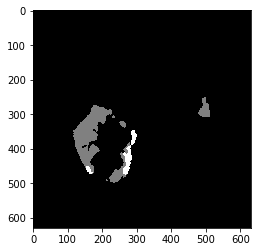

In [5]:
plt.imshow(seg_data[:, :, 30], cmap='gray')

In [6]:
np.unique(seg_data[:, :, 30])

array([0., 1., 2.])

- *mask data に応じて RGB のチャネルをつけて表示させる*
    - **0　:　background　[ 0, 0, 0 ]**
    - **1　:　Red　[ 255, 0, 0 ]**
    - **2　:　Green　[ 0, 255, 0 ]**
    - **3　:　Blue　[ 0, 0, 255 ]**


- <u>Mask data に応じた RGB の data を作成することができる</u>
    - ラベル別に色付けをする　(RGB)

In [7]:
shp = seg_data.shape
seg_color = np.zeros((shp[0], shp[1], shp[2], 3))
seg_color.shape

(630, 630, 45, 3)

In [8]:
zeros = np.zeros((2, 2))
zeros

array([[0., 0.],
       [0., 0.]])

In [9]:
filter_array = np.array([[True, False], [True, False]])
filter_array

array([[ True, False],
       [ True, False]])

In [10]:
zeros[filter_array] = 1
zeros

array([[1., 0.],
       [1., 0.]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


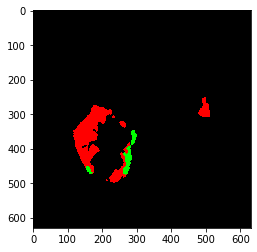

In [11]:
# filter_array = np.where(seg_data==1, True, False)
# filter_array = np.equal(seg_data, 1)
# seg_color[filter_array] = [255, 0, 0]
ggo_color = [255, 0 , 0]
consolidation_color = [0, 255 , 0]
effusion_color = [0, 0 , 255]
seg_color[np.equal(seg_data, 1)] = ggo_color
seg_color[np.equal(seg_data, 2)] = consolidation_color
seg_color[np.equal(seg_data, 3)] = effusion_color
plt.imshow(seg_color[:, :, 30])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


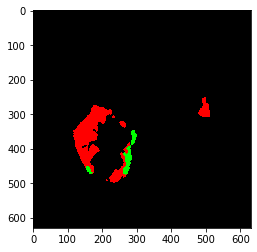

In [12]:
p = df['FilePathMask'].iloc[0]
seg_data = ctvis.load_nifti(p)
shp = seg_data.shape

# 箱を作成　：　全て０の値にする : np./uint8 でもOK, 64bitだとメモリを消費してしまう為 32bitにしている
seg_color = np.zeros((shp[0], shp[1], shp[2], 3), dtype=np.float32)

# カラーラベル定義
ggo_color = [255, 0 , 0]
consolidation_color = [0, 255 , 0]
effusion_color = [0, 0 , 255]

# 色づけ
seg_color[np.equal(seg_data, 1)] = ggo_color
seg_color[np.equal(seg_data, 2)] = consolidation_color
seg_color[np.equal(seg_data, 3)] = effusion_color

# plot : 30枚目
plt.imshow(seg_color[:, :, 30])

## 上記を関数にする

In [13]:
def label_color(mask_volume,
               ggo_coloror = [255, 0 , 0],
               consolidation_color = [0, 255 , 0],
               effusion_color = [0, 0 , 255]):
    shp = mask_volume.shape
    # 箱作成
    mask_color = np.zeros((shp[0], shp[1], shp[2], 3), dtype=np.float32)
    # 色付け
    mask_color[np.equal(mask_volume, 1)] = ggo_color
    mask_color[np.equal(mask_volume, 2)] = consolidation_color
    mask_color[np.equal(mask_volume, 3)] = effusion_color

    return mask_color

In [14]:
mask_color = label_color(seg_data)
mask_color.shape

(630, 630, 45, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


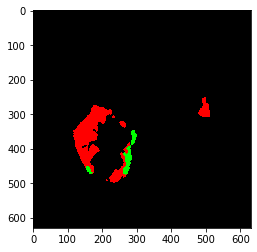

In [15]:
plt.imshow(mask_color[:, :, 30])

## script からの読み込み Test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


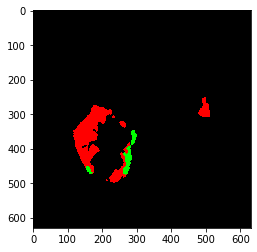

In [16]:
p = df['FilePathMask'].iloc[0]
seg_data = ctvis.load_nifti(p)
mask_color = ctvis.label_color(seg_data)
plt.imshow(mask_color[:, :, 30])